In [4]:
import pandas as pd
import numpy as np
from math import pow
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [5]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [6]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude
def ft_to_meters(ft): return ft * 0.3048

In [7]:
boost_end = 3_500
first_charge = 28_125

altim = df[['pressure (kPa)']].copy()
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

In [8]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)
nice_data['t'] = nice_data.index

In [9]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


In [10]:
def f(x, a, b, c):
    return a*x + c + b / x

In [11]:
def calc_slope(x):
    fit = np.polyfit(x.index, x, 1)
    slope = fit[0]
    return slope

In [12]:
nice_data['vel_m_agl'] = nice_data['alt_m_agl'].rolling(100).apply(calc_slope)

In [13]:
nice_data = nice_data.dropna()

In [27]:
def curve_fit_to_now(row, window_size_sec = 1):
    endt = row.name
    startt = max(endt - window_size_sec, nice_data.iloc[0].name)
    data = nice_data[startt:endt]

    args, stuff = curve_fit(f, nice_data.index, nice_data['vel_m_agl'])
    # poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = lambda x : f(x, *args)



    outs = predictor(nice_data.index.to_series())
    predicted_apogee_index = outs.abs().min().argmin()
    # predicted_apogee, predicted_apogee_index = outs.max(), outs.argmax()
    predicted_apogee_time = nice_data.iloc[predicted_apogee_index].name
    
    pred_vel = predictor(endt)
    return pred_vel, predicted_apogee_time, args[0], args[1], args[2]

In [31]:
window_sizes = [0.25, 0.375, 0.5, 1, 2,5 , 8, 10, 15, 20, 30]

In [32]:
datas = []
for win_size in window_sizes:
    data = nice_data.apply(lambda row : curve_fit_to_now(row, win_size), axis=1, result_type='expand')\
        .rename(columns = {0:'pred_vel', 1:'pred_apogee_t', 2:'e0', 3:'e1', 4:'e2'})

    # data['apogee_diff'] = actual_apogee - data['pred_apogee']
    data['apogee_diff_t'] = actual_apogee_time - data['pred_apogee_t']
    # data['alt_diff'] = nice_data['alt_m_agl'] - data['pred_alt']

    datas.append(data)

/tmp/ipykernel_144306/3032845644.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/tmp/ipykernel_144306/3032845644.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  tx.legend(loc = 'lower right')


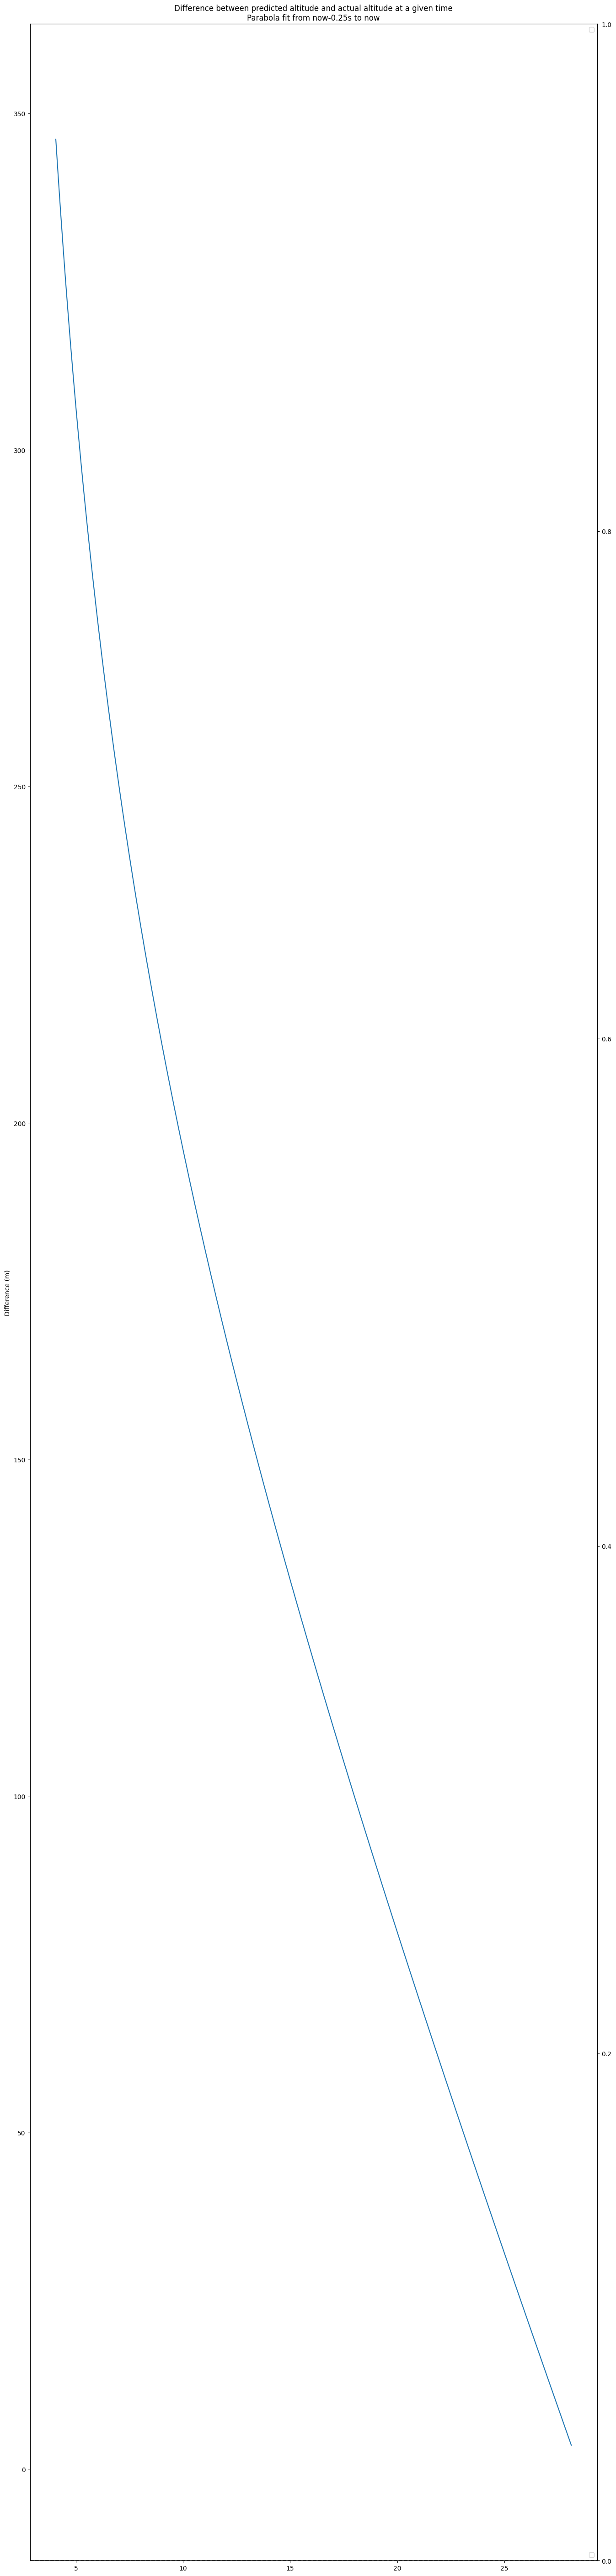

In [30]:
for i, (win_size, data) in enumerate(zip(window_sizes, datas)):
    wdata = data.iloc[60:]

    me0 = wdata['e0'].abs().max()
    me1 = wdata['e1'].abs().max()
    me2 = wdata['e2'].abs().max()

    fig = plt.subplot(len(window_sizes), 1, i+1)

    fig.plot(wdata['pred_vel'])
    tx = fig.twinx()
    # tx.plot(wdata['e1'] / me1, label = f"e0 / {me0:.2f}")
    # tx.plot(wdata['e0'] / me0, label = f"e1 / {me1:.2f}")
    # tx.plot(wdata['e2'] / me2, label = f"e2 / {me2:.2f}")


    madt = wdata['apogee_diff_t'].abs().max()
    tx.plot(wdata['apogee_diff_t'] / madt, label = f"apogee time difference / {madt:.2f}")


    tx.axhline(0, c = 'gray', linestyle = 'dashed')

    fig.set_title(f"Difference between predicted altitude and actual altitude at a given time\nParabola fit from now-{win_size}s to now")
    fig.set_ylabel("Difference (m)")
    fig.legend()
    tx.legend(loc = 'lower right')

fig.get_figure().set_figwidth(16)
fig.get_figure().set_figheight(9*8)
